In [ ]:
import os
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from torchvision import transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
import itertools
import pandas as pd

In [ ]:
import kagglehub
import os

# Download latest version of data from Kaggle
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-classification-mri


In [ ]:
# Print content
for filename in os.listdir(path):
  print(filename)

Training
Testing


In [ ]:
# Load images and labels for training and testing
train_folder = os.path.join(path, 'Training')
test_folder = os.path.join(path, 'Testing')

In [ ]:
# Create function to properly load data as tensors
def load_images_from_folder_v2(train_folder, test_folder):
    image_data = []
    labels = []
    label_encoder = LabelEncoder()

    # Get all tumor types (folder names)
    tumor_types = []
    for folder in [train_folder, test_folder]:
        tumor_types.extend(os.listdir(folder))
    tumor_types = list(set(tumor_types))  # Get unique tumor types

    label_encoder.fit(tumor_types)

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=0, shear=10),
        transforms.RandomCrop(224),
        transforms.ToTensor(),  # Converts grayscale to [1, H, W]
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale
    ])

    # Load images from both folders
    for folder in [train_folder, test_folder]:
        for tumor_type in os.listdir(folder):
            tumor_folder_path = os.path.join(folder, tumor_type)
            if os.path.isdir(tumor_folder_path):
                for image_file in os.listdir(tumor_folder_path):
                    image_path = os.path.join(tumor_folder_path, image_file)
                    if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                        try:
                            img = Image.open(image_path).convert('L')
                            img = transform(img)
                            image_data.append(img)
                            labels.append(label_encoder.transform([tumor_type])[0])
                        except Exception as e:
                            print(f"Error loading image {image_path}: {e}")

    # Stack, shuffle, and convert to tensors
    image_data = torch.stack(image_data)
    labels = torch.tensor(labels)
    image_data, labels = shuffle(image_data.numpy(), labels.numpy(), random_state=42)
    image_data = torch.tensor(image_data)
    labels = torch.tensor(labels)

    return image_data, labels, label_encoder

In [ ]:
# Load data as tensor
X, y, label_encoder = load_images_from_folder_v2(train_folder, test_folder)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Print out the shapes and label mapping for verification
print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Label encoding: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

Train data shape: torch.Size([2611, 1, 224, 224])
Test data shape: torch.Size([653, 1, 224, 224])
Label encoding: {np.str_('glioma_tumor'): 0, np.str_('meningioma_tumor'): 1, np.str_('no_tumor'): 2, np.str_('pituitary_tumor'): 3}


In [ ]:
# Print label encoding mapping (label -> encoded number)
print("Label encoding mapping:")
for label, encoded_value in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"Label: {label} -> Encoded number: {encoded_value}")

Label encoding mapping:
Label: glioma_tumor -> Encoded number: 0
Label: meningioma_tumor -> Encoded number: 1
Label: no_tumor -> Encoded number: 2
Label: pituitary_tumor -> Encoded number: 3


In [ ]:
# Print first image
X_train[2000]

tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.9686, -0.9686, -0.9686,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9686, -0.9686, -0.9686,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9686, -0.9686, -0.9686,  ..., -1.0000, -1.0000, -1.0000]]])

In [ ]:
# Print first image label
y_train[15]

tensor(1)

In [ ]:
# Create TensorDataset from X_train and y_train
train_data = TensorDataset(X_train, y_train)
# Create TensorDataset from X_test and y_test
test_data = TensorDataset(X_test, y_test)

In [ ]:
# Create small batch size of 32 images
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
print("Unique labels:", label_encoder.classes_)

Unique labels: ['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


In [ ]:
# Make CNN Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self, dropout = 0.2):
    super().__init__()

    # Convolution layer
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Pooling layer
    self.adaptive_pool = nn.AdaptiveAvgPool2d((8,8))

    # Fully connected layer
    self.fc1 = nn.Linear(in_features=32*8*8, out_features=128)
    self.dropout = nn.Dropout(0.2)
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Flatten data
    self.flatten = nn.Flatten()

  # Feed forward
  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.pool(x)
    x = F.relu(self.bn2(self.conv2(x)))
    x = self.pool(x)
    x = self.adaptive_pool(x)
    x = self.flatten(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [ ]:
# Create instance
cnn = ConvolutionalNetwork()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001, weight_decay= 0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
train_losses = []
train_accuracies = []  # Store training accuracy for each epoch
epochs = 20

cnn.train()

for epoch in range(epochs):
  running_loss = 0.0
  correct_predictions = 0  # Track correct predictions for the epoch
  total_samples = 0  # Track total samples for the epoch

  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = cnn(images)
    loss_value = loss(outputs, labels)
    loss_value.backward()
    optimizer.step()

    running_loss += loss_value.item() * images.size(0)

    # Calculate accuracy for the batch
    _, predicted = torch.max(outputs, 1)
    correct_predictions += (predicted == labels).sum().item()
    total_samples += labels.size(0)

  epoch_loss = running_loss / len(train_loader.dataset)
  train_losses.append(epoch_loss)

  # Calculate and store accuracy for the epoch
  epoch_accuracy = correct_predictions / total_samples
  train_accuracies.append(epoch_accuracy)
  scheduler.step(epoch_loss)

  print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

cnn.eval()

Epoch 1/20, Loss: 1.1750, Accuracy: 0.4810
Epoch 2/20, Loss: 1.0205, Accuracy: 0.5714
Epoch 3/20, Loss: 0.9532, Accuracy: 0.6074
Epoch 4/20, Loss: 0.9186, Accuracy: 0.6247
Epoch 5/20, Loss: 0.8490, Accuracy: 0.6549
Epoch 6/20, Loss: 0.8191, Accuracy: 0.6676
Epoch 7/20, Loss: 0.7906, Accuracy: 0.6810
Epoch 8/20, Loss: 0.7754, Accuracy: 0.6794
Epoch 9/20, Loss: 0.7649, Accuracy: 0.6856
Epoch 10/20, Loss: 0.7158, Accuracy: 0.7097
Epoch 11/20, Loss: 0.7006, Accuracy: 0.7101
Epoch 12/20, Loss: 0.6773, Accuracy: 0.7250
Epoch 13/20, Loss: 0.6538, Accuracy: 0.7396
Epoch 14/20, Loss: 0.6305, Accuracy: 0.7461
Epoch 15/20, Loss: 0.6006, Accuracy: 0.7595
Epoch 16/20, Loss: 0.5860, Accuracy: 0.7625
Epoch 17/20, Loss: 0.5602, Accuracy: 0.7698
Epoch 18/20, Loss: 0.5517, Accuracy: 0.7775
Epoch 19/20, Loss: 0.5324, Accuracy: 0.7882
Epoch 20/20, Loss: 0.5060, Accuracy: 0.7936


ConvolutionalNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(8, 8))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:

#10 epoch .19 dropout: --
#10 epoch .2 dropout: 69.98
#10 epoch .25 dropout: 67.08
#10 epoch .5 dropout: 61.26

#20 epoch .10 dropout: 73.51

num_correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = cnn(images)
    predictions = torch.argmax(outputs, dim=1)

    for i in range(len(labels)):
      if(predictions[i].item() == labels[i].item()):
        num_correct += 1
      total += 1

print(f"{round((num_correct/total) * 100, 2)}% correct")

73.05% correct


In [ ]:
#Test the data
test_losses = []  # Initialize test_losses as an empty list
test_correct = [] # Initialize test_correct as an empty list
# Redefine the loss function
criterion = nn.CrossEntropyLoss()

# Store test accuracy for each epoch
epoch_test_correct = []

with torch.no_grad(): # No gradient so we don't update our weights and biases for test data
    for epoch in range(epochs):  # Iterate through epochs
        total_correct_epoch = 0  # Track correct predictions for this epoch
        for b, (X_test, y_test) in enumerate(test_loader):
            # Use 'cnn' instead of 'model' to make predictions
            y_val = cnn(X_test.to(device))  # Move X_test to the device
            predicted = torch.max(y_val.data, 1)[1]  # Add up correct predictions

            # Accumulate correct predictions for the epoch
            total_correct_epoch += (predicted == y_test.to(device)).sum().item()

            # Calculate and append loss for each batch
            loss_value = criterion(y_val, y_test.to(device))  # Move y_test to the device for loss calculation, rename to avoid overwriting the loss function
            test_losses.append(loss_value.item())  # Append the loss value for the current batch

        # Append the total correct predictions for this epoch
        epoch_test_correct.append(total_correct_epoch)

test_correct = epoch_test_correct # Assign epoch-wise test accuracy to test_correct

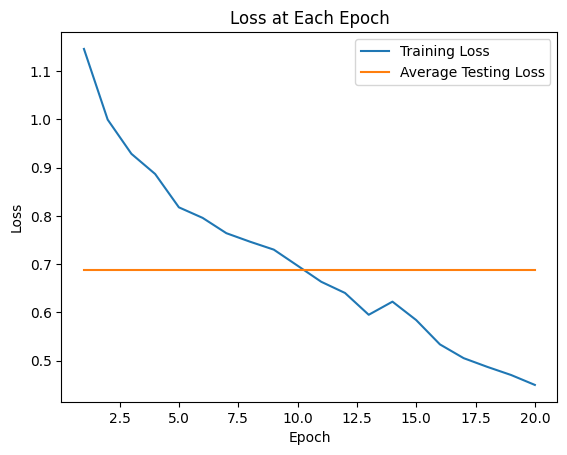

In [ ]:
# Graph loss at each epoch
epochs_list = list(range(1, epochs + 1))

plt.plot(epochs_list, train_losses, label='Training Loss')
# Calculate average test loss per epoch
avg_test_loss_per_epoch = [sum(test_losses[i*len(test_loader):(i+1)*len(test_loader)]) / len(test_loader)
                          for i in range(epochs)]
plt.plot(epochs_list, avg_test_loss_per_epoch, label='Average Testing Loss') # Plot average test loss
plt.title('Loss at Each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

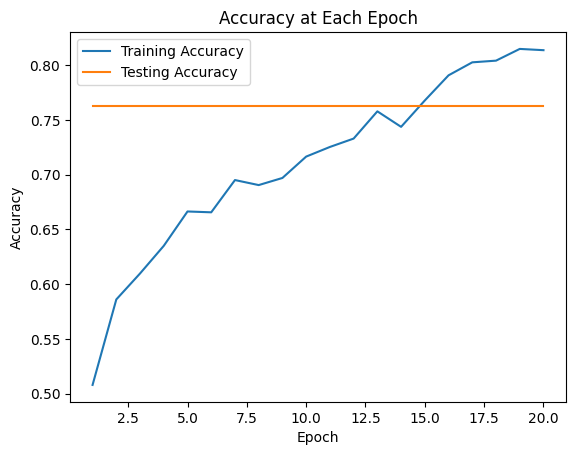

In [ ]:
# Graph accuracy at each epoch
epochs_list = list(range(1, epochs + 1))  # Use epochs_list for x-axis
plt.plot(epochs_list, train_accuracies, label='Training Accuracy')

# Calculate and store testing accuracy for each epoch
test_accuracies = [t/len(test_loader.dataset) for t in test_correct]

# Ensure that test_accuracies is padded to the same length as epochs_list
# for example, if test_accuracies has fewer values than epochs_list
test_accuracies.extend([test_accuracies[-1]] * (len(epochs_list) - len(test_accuracies)))

plt.plot(epochs_list, test_accuracies, label = 'Testing Accuracy')  # Assuming test_correct is a list of correct predictions for each epoch
plt.title('Accuracy at Each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Calculate accuracy
with torch.no_grad():
  correct = 0
  # Iterate through the test_loader
  for X_test, y_test in test_loader:
    # Use 'cnn' instead of 'model' since 'cnn' is your defined model
    y_val = cnn(X_test.to(device))  # Move X_test to the device
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test.to(device)).sum() # Move y_test to the device

# Correct number
accuracy = correct.item() / len(test_data) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 76.26%


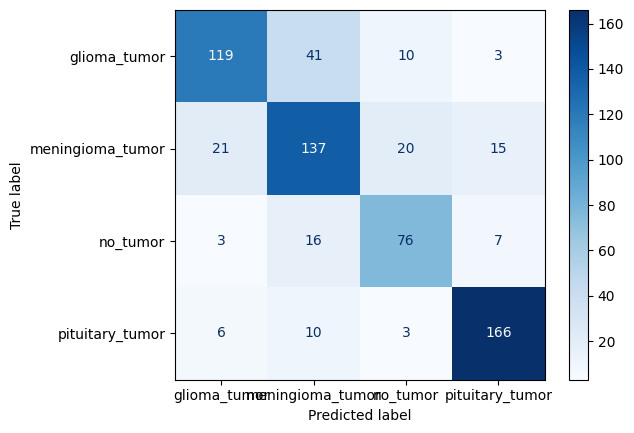

In [ ]:
# Confusion matrix
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    output = cnn(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Precision
precision = precision_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
print(f"Precision: {precision:.4f}")

Precision: 0.7652


In [ ]:
# Recall
recall = recall_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class

print(f"Recall: {recall:.4f}")

Recall: 0.7626


In [ ]:
# F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class

print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7625


In [ ]:
# Define your hyperparameter grid
param_grid = {
    'lr': [0.001, 0.0005],
    'batch_size': [32, 64],
    'dropout': [0.2, 0.4]
}
param_combinations = list(itertools.product(*param_grid.values()))
results = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create DataLoaders with the first parameter combination for initial data loading
first_batch_size = param_combinations[0][1]  # Get the first batch size
train_loader_iter = DataLoader(train_data, batch_size=first_batch_size, shuffle=True)
val_loader_iter = DataLoader(test_data, batch_size=first_batch_size, shuffle=False)

# Run grid search
for lr, batch_size, dropout in param_combinations:
    model = ConvolutionalNetwork(dropout=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Update batch size if it has changed
    if batch_size != train_loader_iter.batch_size:
        train_loader_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader_iter = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    for epoch in range(20):
        model.train()
        # Use the new DataLoader instances for this iteration
        for images, labels in train_loader_iter:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader_iter:  # Use the validation DataLoader
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    results.append({
        'Learning Rate': lr,
        'Batch Size': batch_size,
        'Dropout': dropout,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

# Create and export results table
df = pd.DataFrame(results)  # No sorting
print(df)

   Learning Rate  Batch Size  Dropout  Accuracy  Precision    Recall  F1 Score
0         0.0010          32      0.2  0.633997   0.636506  0.635153  0.629632
1         0.0010          32      0.4  0.664625   0.655942  0.679371  0.662992
2         0.0010          64      0.2  0.646248   0.651815  0.620170  0.628997
3         0.0010          64      0.4  0.595712   0.601974  0.572962  0.576261
4         0.0005          32      0.2  0.658499   0.648733  0.674901  0.654656
5         0.0005          32      0.4  0.635528   0.647901  0.650863  0.619987
6         0.0005          64      0.2  0.621746   0.622871  0.613984  0.591469
7         0.0005          64      0.4  0.597243   0.598094  0.572470  0.571575


SVM Model and Random Forest Classifier Model and Logistic Regression Model Comparison

Path to dataset files: /kaggle/input/brain-tumor-classification-mri
Total images: 3264 | Classes: {'no_tumor': 0, 'pituitary_tumor': 1, 'meningioma_tumor': 2, 'glioma_tumor': 3}
Feature shape: (3264, 4096)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.71      0.78       171
           1       0.93      0.97      0.95       282
           2       0.76      0.74      0.75       272
           3       0.74      0.82      0.78       255

    accuracy                           0.82       980
   macro avg       0.83      0.81      0.81       980
weighted avg       0.82      0.82      0.82       980



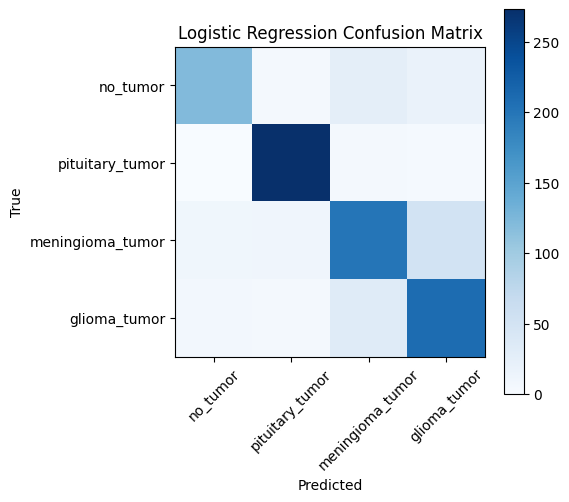


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       171
           1       0.93      0.98      0.95       282
           2       0.83      0.88      0.85       272
           3       0.93      0.81      0.87       255

    accuracy                           0.89       980
   macro avg       0.89      0.89      0.89       980
weighted avg       0.89      0.89      0.89       980



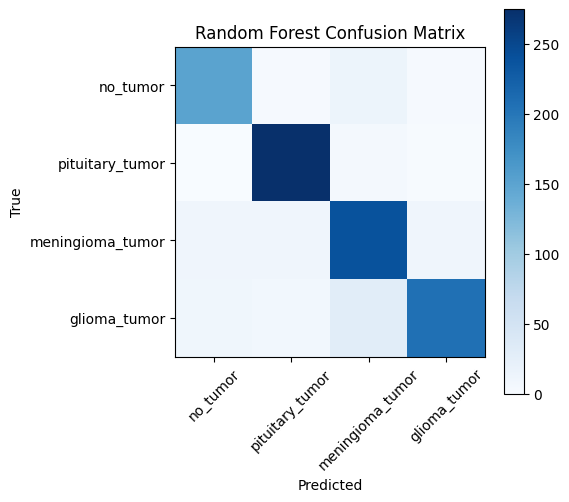


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       171
           1       0.95      0.98      0.96       282
           2       0.78      0.72      0.75       272
           3       0.77      0.83      0.80       255

    accuracy                           0.83       980
   macro avg       0.83      0.83      0.83       980
weighted avg       0.83      0.83      0.83       980



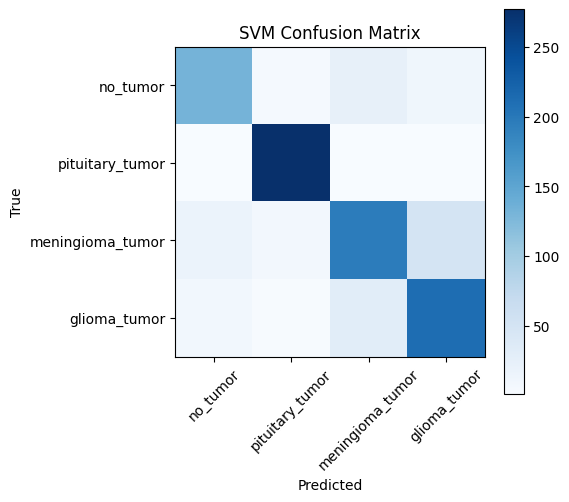

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import kagglehub


path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")
print("Path to dataset files:", path)


train_path = os.path.join(path, 'Training')
test_path = os.path.join(path, 'Testing')


def get_image_files_and_labels(directory):
    image_paths = []
    labels = []
    label_dict = {}
    current_label = 0

    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            if folder not in label_dict:
                label_dict[folder] = current_label
                current_label += 1
            for file in os.listdir(folder_path):
                if file.endswith('.jpg') or file.endswith('.png'):
                    image_paths.append(os.path.join(folder_path, file))
                    labels.append(label_dict[folder])
    return image_paths, labels, label_dict

train_images, train_labels, label_dict = get_image_files_and_labels(train_path)
test_images, test_labels, _ = get_image_files_and_labels(test_path)

all_images = train_images + test_images
all_labels = train_labels + test_labels

print(f"Total images: {len(all_images)} | Classes: {label_dict}")

def extract_image_features(image_paths, size=(64, 64)):
    features = []
    for path in image_paths:
        try:
            img = Image.open(path).convert('L')
            img = img.resize(size)
            img_array = np.array(img).flatten()
            features.append(img_array)
        except Exception as e:
            print(f"Error processing {path}: {e}")
    return np.array(features)

X = extract_image_features(all_images)
y = np.array(all_labels)

print("Feature shape:", X.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)


def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Classification Report:")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(np.arange(len(label_dict)), label_dict.keys(), rotation=45)
    plt.yticks(np.arange(len(label_dict)), label_dict.keys())
    plt.colorbar()
    plt.show()

evaluate_model("Logistic Regression", y_test, y_pred_log)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("SVM", y_test, y_pred_svm)


def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Classification Report:")
    print(classification_repor